In [1]:
try:
    passes += 1
    !git pull
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet

Cloning into 'FoolsUNet'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 357 (delta 127), reused 41 (delta 31), pack-reused 155 (from 1)
Receiving objects: 100% (357/357), 109.87 MiB | 28.94 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (41/41), done.
/kaggle/working/FoolsUNet


In [2]:
import tensorflow as tf

print(tf.__version__)

2024-09-24 19:02:52.073166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 19:02:52.073274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 19:02:52.211295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [3]:
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))

In [4]:
import tensorflow_datasets as tfds

In [5]:
dataset, info = tfds.load("imagenette/320px-v2:1.*.*", with_info=True, data_dir="./data/")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteU2EXUV/imagenette-train.tfrecord*...:   0%|          | 0/94…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling data/imagenette/320px-v2/1.0.0.incompleteU2EXUV/imagenette-validation.tfrecord*...:   0%|          |…

Dataset imagenette downloaded and prepared to ./data/imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


In [6]:
dataset

{Split('train'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [7]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [8]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [9]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["validation"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [12]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [13]:
from foolsunet.model import foolsunet

In [14]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
    #base_model_1 = tf.keras.models.load_model("foolsunet_imagenet_resized_6-9_epoch.keras")
    base_model_2 = foolsunet(channel_attention="eca")
    #base_model_1.summary()

### Define encoder

In [15]:
# Use the activations of these layers
layer_names = [
    'block_1_downsample',   # 64x64
    'block_2_downsample',] # 32x32
base_model_layers = [base_model_2.get_layer(name) for name in layer_names]
layer_names = [
    'block_3_invres_downsample',   # 16x16
    'block_4_invres_downsample',  # 8x8
    'block_5_invres_downsample',      # 4x4
    'block_6_invres_downsample'
]
base_model_layers += [base_model_2.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

In [16]:
def assemble_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Conv2D(1024, 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Activation("relu6")(x)
    x = tf.keras.layers.AveragePooling2D(4)(x)
    x = tf.keras.layers.Conv2D(num_classes, 1)(x)
    x = tf.keras.layers.Flatten(name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
num_classes = 10
# classification_head = tf.keras.Sequential([
#     tf.keras.layers.Input([8,8,128]),
#     tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes, name="outputs"),])
# # classification_head.build()

In [18]:
# model = tf.keras.Sequential([base_model.get_layer(name) for name in layer_names] + [layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs"),
#                                                                                    ])
# model.build()

In [19]:
with strategy.scope():
    model = assemble_model()
    opt = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(
    optimizer=opt,
    #Anything between 2 and `steps_per_epoch` could help here.
    #steps_per_execution = 50,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
    model.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │        81,049 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       143,977 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       251,013 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │       541,897 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_138 (Activation)     │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 1, 1, 10)       │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Flatten)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,305,882 (4.98 MB)

 Trainable params: 1,283,454 (4.90 MB)

 Non-trainable params: 22,428 (87.61 KB)

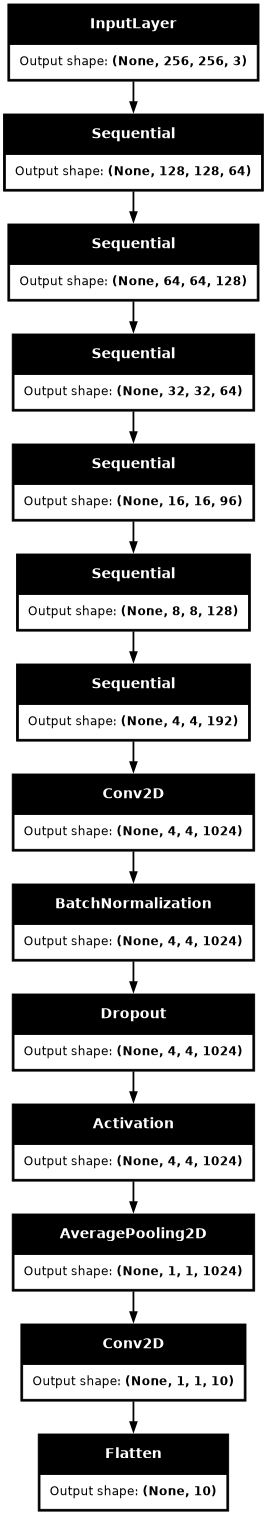

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["validation"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
    # callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, start_from_epoch=10)],
)

Epoch 1/20


2024-09-24 19:04:40.594845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_14_1/block_3_invres_downsample_1/aspp_block_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 ━━━━━━━━━━━━━━━━━━━━ 183s 841ms/step - accuracy: 0.2814 - loss: 2.2192 - val_accuracy: 0.0872 - val_loss: 3.0091
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 120s 811ms/step - accuracy: 0.5391 - loss: 1.4044 - val_accuracy: 0.1003 - val_loss: 2.5380
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.6505 - loss: 1.0758 - val_accuracy: 0.5091 - val_loss: 1.6240
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.7099 - loss: 0.9040 - val_accuracy: 0.4531 - val_loss: 3.5758
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 810ms/step - accuracy: 0.7360 - loss: 0.8198 - val_accuracy: 0.5547 - val_loss: 2.8752
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 805ms/step - accuracy: 0.7777 - loss: 0.7048 - val_accuracy: 0.5059 - val_loss: 2.7585
Epoch 7/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 812ms/step - accuracy: 0.7883 - loss: 0.6594 - val_accuracy: 0.4245 - val_loss: 4.0943
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 810ms/step - accuracy: 0.8006 - loss: 0.6097 - val_accuracy: 0.5911 - val_loss: 2.1256
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.8214 - loss: 0.5574 - val_accuracy: 0.6406 - val_loss: 1.9643
Epoch 10/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.8310 - loss: 0.5160 - val_accuracy: 0.5039 - val_loss: 3.5410
Epoch 11/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.8434 - loss: 0.4883 - val_accuracy: 0.7474 - val_loss: 1.0906
Epoch 12/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 800ms/step - accuracy: 0.8581 - loss: 0.4385 - val_accuracy: 0.6941 - val_loss: 1.2288
Epoch 13/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 812ms/step - accuracy: 0.8651 - loss: 0.4262 - val_accuracy: 0.6419 - val_loss: 1.7498
Epoch 14/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 119s 811ms/step - accuracy: 0.8756 - loss:

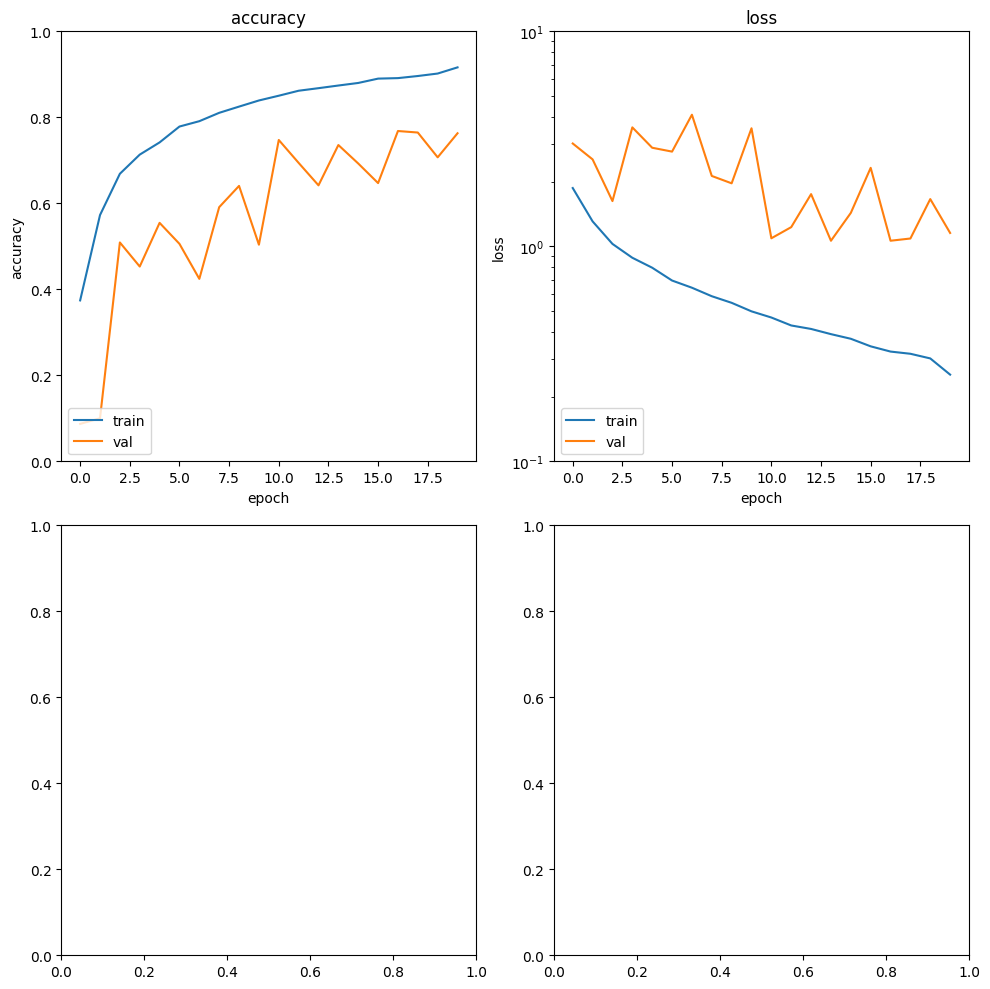

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].plot(model_history.history["accuracy"])
ax[0, 0].plot(model_history.history["val_accuracy"])
ax[0, 0].set_title("accuracy")
ax[0, 0].set_ylabel("accuracy")
ax[0, 0].set_xlabel("epoch")
ax[0, 0].set_ylim(0.0,1.0)
ax[0, 0].legend(["train", "val"], loc="lower left")


ax[0, 1].plot(model_history.history["loss"])
ax[0, 1].plot(model_history.history["val_loss"])
ax[0, 1].set_yscale("log")
ax[0, 1].set_title("loss")
ax[0, 1].set_ylabel("loss")
ax[0, 1].set_xlabel("epoch")
ax[0, 1].set_ylim(0.1,10.0)
ax[0, 1].legend(["train", "val"], loc="lower left")

# ax[1, 0].plot(model_history.history["regression_output_weighted_mse"])
# ax[1, 0].plot(model_history.history["val_regression_output_weighted_mse"])
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_title("val_regression_output_weighted_mse")
# ax[1, 0].set_ylabel("accuracy")
# ax[1, 0].set_xlabel("epoch")
# ax[1, 0].legend(["train", "val"], loc="lower left")

fig.tight_layout()

In [23]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenette.keras")

In [24]:

model.save_weights("foolsunet_imagenette.weights.h5")

In [25]:
new_model = tf.keras.models.load_model("foolsunet_imagenette.keras")

# Show the model architecture
new_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │        81,049 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       143,977 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       251,013 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_invres_downsample       │ (None, 4, 4, 192)      │       541,897 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 4, 4, 1024)     │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_144         │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_138 (Activation)     │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 1024)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 1, 1, 10)       │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Flatten)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,872,792 (14.77 MB)

 Trainable params: 1,283,454 (4.90 MB)

 Non-trainable params: 22,428 (87.61 KB)

 Optimizer params: 2,566,910 (9.79 MB)